# Next Casualty Prediction

## Data Formatting

In [1]:
# Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import time
from sklearn.model_selection import train_test_split
import torchvision.models as models
from torch.utils.data import Dataset
import torch.optim as optim
from tqdm import tqdm
import os

In [2]:
!ls ../data

dataset-20220422-195516.npz  dataset-20220429-231916.npz


In [3]:
## Borrowed functions from Sean
def imshow(image, ax=None, title=None, stride=1, **kwargs):
    # A simple helper function for plotting images with (C, H, W) format instead of (H, W, C)
    if ax is None:
        fig, ax = plt.subplots(**kwargs)

    if isinstance(image, Image.Image):  # checking if PIL image
        if stride==1:
            ax.imshow(image)
        else:
            image = np.array(image)
    if len(image.shape) == 2:
        # we are in a grayscale domain -- stack it to make it n_channels=3 (yes, it's hacky)
#         image = np.vstack([image[:, :, np.newaxis], image[:, :, np.newaxis], image[:, :, np.newaxis]])
        image = np.vstack([image[np.newaxis, :, :], image[np.newaxis, :, :], image[np.newaxis, :, :]])

    if image.shape[0] == 3:  # if image.shape = (C, H, W)
        if isinstance(image, torch.Tensor):
            ax.imshow(image[:, ::stride, ::stride].transpose(2,0))
        else:
            ax.imshow(image[:, ::stride, ::stride].transpose(2,1,0))
    else:  # if image.shape = (H, W, C), i.e. no channel moving needed
        ax.imshow(image[::stride, ::stride, :])
    ax.set_title(title)
    return ax

def make_color_context_battle_frame(player_relative, dtype=float, multiplyer=1):
    # Colorizing battle frame based off of friendly, hostile, or neurtal
    # player_relative: Which units are friendly vs hostile. 
    #  Takes values in [0, 4], denoting 
    #  [background, self, ally, neutral, enemy] units respectively.
#     background = player_relative==0
    blue_team = player_relative==1
#     ally_team = player_relative==2
    neutral = player_relative==3
    red_team = player_relative==4
    return np.stack([red_team, neutral, blue_team]).astype(dtype) * multiplyer


In [4]:
def get_dataset(npz_file):
    data = np.load(npz_file)
    return data

def list_features(data):
    for d in data:
        print(d, data[d].shape)

data = get_dataset("../data/dataset-20220422-195516.npz")
list_features(data)

minimap_height_map (9830, 224, 224)
minimap_visibility_map (9830, 224, 224)
minimap_creep (9830, 224, 224)
minimap_camera (9830, 224, 224)
minimap_player_id (9830, 224, 224)
minimap_player_relative (9830, 224, 224)
minimap_selected (9830, 224, 224)
minimap_unit_type (9830, 224, 224)
screen_height_map (9830, 84, 84)
screen_visibility_map (9830, 84, 84)
screen_creep (9830, 84, 84)
screen_power (9830, 84, 84)
screen_player_id (9830, 84, 84)
screen_player_relative (9830, 84, 84)
screen_unit_type (9830, 84, 84)
screen_selected (9830, 84, 84)
screen_unit_hit_points (9830, 84, 84)
screen_unit_hit_points_ratio (9830, 84, 84)
screen_unit_energy (9830, 84, 84)
screen_unit_shields (9830, 84, 84)
screen_unit_density (9830, 84, 84)
screen_unit_density_aa (9830, 84, 84)
dead_units (9830,)
next_dead (9830,)
screen_unit_count (9830,)


In [5]:
class CustomDataset(Dataset):
    def __init__(self, X, y, transform_pipeline=None):
        super().__init__()
        self.X = X
        self.y = torch.Tensor(y)
        
        if not transform_pipeline:
            class No_operation:
                def __call__(self, x):
                    return x
            
            transform_pipeline = No_operation()
        self.transform = transform_pipeline
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        current_features = self.transform(self.X[idx])
        current_target = self.y[idx]
        
        return current_features, current_target.float()

In [6]:
class CustomToTensor:
    def __call__(self, x):
        if x.shape[0] != 3 and len(x.shape) > 2:
            # x.shape=[H x W x C], change it to [C x H x W]
            x = x.transpose(2, 1, 0)
        x = torch.Tensor(x)
        if not torch.is_floating_point(x):
            # assume we are in the [0, 255] range, so convert to [0,1]
            x /= 255
        return x

In [7]:
def filter_dataset(X, y):
    X_filtered = []
    y_filtered = []
    
    for idx in range(len(y)):
        if(y[idx] <= 100):
            y_filtered.append(y[idx])
            X_filtered.append(X[idx])
    
    return X_filtered, y_filtered

In [8]:
def create_dataloaders(data, split=True, visualize=False):
    X = data["minimap_player_relative"]
    X = np.array([make_color_context_battle_frame(frame) for frame in X])
    y = data["next_dead"]
    
    X, y = filter_dataset(X, y)
    
    validation_loader = None
    
    if(split):
        X, X_validation, y, y_validation = train_test_split(X, y, test_size = 0.2, random_state = 42)
    
    if(visualize):
        imshow(X[0], title='Example: Train frame 0')
        plt.show()
        
    train_dataset = CustomDataset(X, y, transform_pipeline=CustomToTensor())
    
    if(split):
        validation_dataset = CustomDataset(X_validation, y_validation, transform_pipeline=CustomToTensor())
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=126)
    
    if(split):
        validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=126)
    
    return train_loader, validation_loader

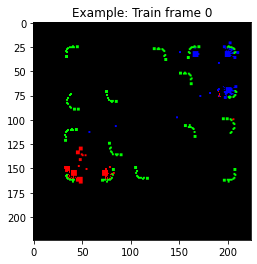

In [9]:
train_loader, validation_loader = create_dataloaders(data, visualize=True)

## Regression Problem

In [10]:
# Loading Resnet Model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

resnet18 = models.resnet18(pretrained = True, progress = True) 
resnet18.fc = nn.Linear(in_features=512, out_features=1, bias=True)
resnet18 = resnet18.to(device)

In [11]:
def train_epoch(classifier, train_loader, optimizer, criterion, epoch, print_loss = False):
    classifier.train()
    train_loss = 0
    
    for batch_idx, (images, targets) in enumerate(train_loader):
        images = images.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        output = classifier(images).squeeze()
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    if(print_loss):
        print(f'Train result on epoch {epoch}: Avg loss is {train_loss / len(train_loader.dataset)}')
        
    return train_loss / len(train_loader)

def train_model(classifier, train_loader, optimizer, criterion, epoch, print_loss = False):
    epoch_loss = train_epoch(resnet18, train_loader, optimizer, criterion, epoch, print_loss)
    return epoch_loss
        
def validate_epoch(classifier, validation_loader, criterion, epoch, print_loss = False):
    classifier.eval()
    validation_loss = 0
    with torch.no_grad():
        for images, targets in validation_loader:
            images = images.to(device)
            targets = targets.to(device)
            output = classifier(images).squeeze()
            validation_loss += criterion(output, targets).item()
    
    validation_loss /= len(validation_loader.dataset)
    if(print_loss):
        print(f'Validation result on epoch {epoch}: Avg loss is {validation_loss}')
        
    return validation_loss

def validate_model(classifier, validation_loader, criterion, epoch, print_loss = False):
    epoch_loss = validate_epoch(resnet18, validation_loader, criterion, epoch, print_loss)
    return epoch_loss

def learning(classifier, train_loader, validation_loader, optimizer, criterion, epoch, print_train_loss = False, print_validation_loss = False):
    train_epoch_loss_history = []
    validation_epoch_loss_history = []
    
    best_validation_epoch_loss = float('inf')
    
    for i in tqdm(range(1, epoch+1)):
        train_epoch_loss = train_model(classifier, train_loader, optimizer, criterion, i, print_train_loss)
        train_epoch_loss_history.append(train_epoch_loss)
        
        validation_epoch_loss = validate_model(classifier, validation_loader, criterion, i, print_validation_loss)
        
        if(validation_epoch_loss < best_validation_epoch_loss):
            best_validation_epoch_loss = validation_epoch_loss
            torch.save(classifier.state_dict(), os.getcwd() + "/models")
        
        validation_epoch_loss_history.append(validation_epoch_loss)
        
    classifier.load_state_dict(torch.load(os.getcwd() + "/models"))
        
    return classifier, train_epoch_loss_history, validation_epoch_loss_history

In [12]:
def plot_losses(epoch, train_loss, validation_loss, marker=None):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharey=True)
    ax1.plot(range(11, epoch+1), train_loss[10:], color="red", marker=marker, label="Train")
    ax1.set_ylabel("Train Loss")
    
    ax2.plot(range(11, epoch+1), validation_loss[10:], color="blue", marker=marker, label="Validation")
    ax2.set_ylabel("Validation Loss")
    
    ax2.set_xlabel("Epochs")
    plt.show()

In [13]:
epoch = 1000
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet18.parameters()), lr=0.01)
criterion = nn.MSELoss()

classifier, train_loss, validation_loss = learning(resnet18, train_loader, validation_loader, optimizer, criterion, epoch)
print(f'First training loss: {train_loss[0]} and Last (Epoch {epoch}) training loss: {train_loss[-1]}')
print(f'First validation loss: {validation_loss[0]} and Last (Epoch {epoch}) validation loss: {validation_loss[-1]}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [49:25<00:00,  2.97s/it]

First training loss: 869.6343872070313 and Last (Epoch 1000) training loss: 1.6617317974567414
First validation loss: 78.53196668388429 and Last (Epoch 1000) validation loss: 0.1495109242841232


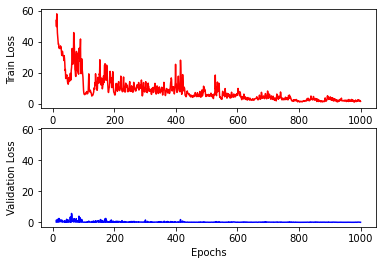

In [14]:
plot_losses(epoch, train_loss, validation_loss)

In [15]:
def compare_prediction_actual(dataloader, classifier, num_samples=10):
    rng = np.random.RandomState(42)
    classifier.eval()
    for (images, target) in dataloader:
        images = images.to(device)
        target = target.to(device)

        with torch.no_grad():
            predictions = classifier(images)
        break
        
    for sample_idx in range(num_samples):
        idx = rng.choice(predictions.shape[0])
        imshow(images[idx].cpu(), ax=None, title=f"The Actual Casualty: {target[idx]} and Predicted Casualty: {int(predictions[idx])}")
    
    return images, target, predictions

In [16]:
test_data = get_dataset("../data/dataset-20220429-231916.npz")
test_loader, _ = create_dataloaders(test_data, split=False)

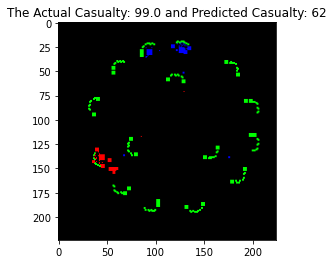

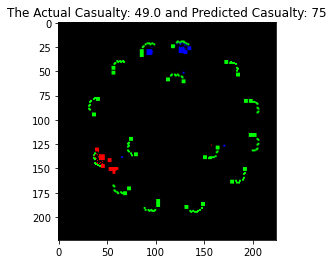

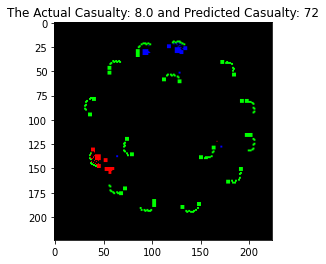

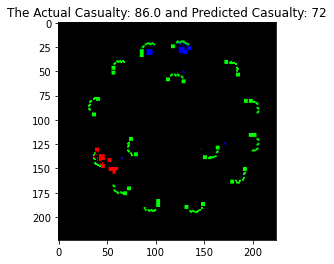

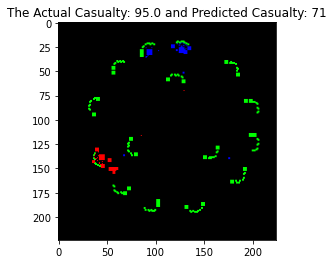

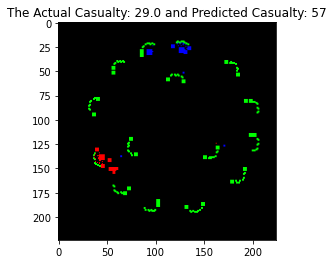

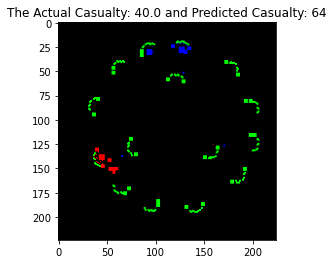

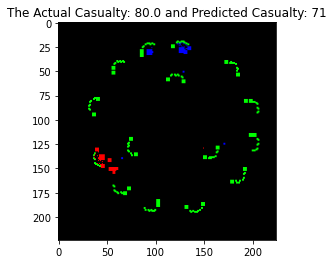

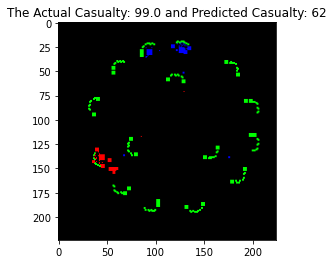

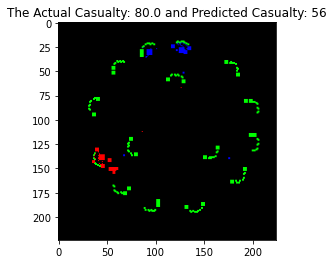

In [17]:
_ = compare_prediction_actual(test_loader, classifier)

## Classification Problem